In [1]:
#### %matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%pylab inline
from __future__ import division
import os
import numpy as np
import pandas as pd
import random
from random import randint

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

Populating the interactive namespace from numpy and matplotlib


## 1. Prepare Input for Simulations

In [9]:
def textPlot(ax, fs, font):
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(font)
        label.set_fontsize(fs)
    return ax

### 1.1 Define Class

In [ ]:
class mosquitoAnalysis:
    def __init__(self):
        self.r0 = 100  ## Distance between cells
        self.a = 2
        self.k = 1500
        self.gs = 20 ## Cells per side
        self.S = self.gs*self.gs ## Grid Size
        self.nc = 100 ## Number of habitants per cells
        self.N = self.nc*self.S
        self.hc = []  ## home work
        self.wc = []  ## home work
        
    def levy(self, r):
        return exp(-r/self.k)*(r + self.r0)**(-self.a)
    
    def defineProbability(self,r):
        p = []  ## probability
        R = []  ## distance
        for i in range(0,60000):
            R.append(r)
            p.append(self.levy(r)*10000)
            r+=.01
        dr = np.array(R)
        dp = np.array(p)
        return (dr,dp)
    
    def find_nearest(self, array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    
    def computeDistance(self):
        d = []
        I = []
        J = []
        count = 0
        for i in range(0, self.S):
            for j in range(0, self.S):
                if i == j: continue
                x1,x2 = i%self.gs, j%self.gs
                y1,y2 = i//self.gs, j//self.gs
                dist = sqrt( float(x1-x2)**2 + float(y1-y2)**2)  # pythagoras theorem
                #dist = abs(x1-x2) + abs(y1-y2)
                dist *= self.r0
                d.append(dist)
                I.append(i)
                J.append(j) 
        self.dc=pd.DataFrame()
        self.dc['i']=I
        self.dc['j']=J
        self.dc['d']=d
    
    
    def assignCells(self, dp, dr):
        nagents = np.arange(0,self.N)
        cell = 0
        upd = self.nc
        same = int(0.2*upd)
        MR = np.zeros((self.gs, self.gs))
        for i in range(0, self.S):  ### For all the cell
            for j in range(0,self.nc): ## For each agent in the cell
                self.hc.append(cell)
                if j < same:  ## First 20 assign same home/work cell
                    self.wc.append(cell)
                else:
                    rand = random.uniform(0, 1)
                    fd = self.find_nearest(dp, rand)
                    wx = np.where(dp==fd)
                    dx = dr[wx[0][0]]
                    tmp = self.dc[self.dc['i']==cell]
                    ft = self.find_nearest(tmp['d'], dx)
                    tmp = tmp[tmp['d']==ft]
                    k = randint(0,len(tmp)-1)
                    idx = tmp.index[k]
                    self.wc.append(tmp['j'][idx])
            cell+=1

### 1.2 Call Class

In [ ]:
mos = mosquitoAnalysis()
mos.computeDistance()  ## compute distance between all the cell
r = 1
[dr,dp] = mos.defineProbability(r) ## define probablity distribution range
mos.assignCells(dp,dr) ## assign the cells given the probability defined below

In [ ]:
fig,ax = plt.subplots(figsize=(5,3))
ax = textPlot(ax, 12, 'Arial')
plt.plot(dr,dp)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Distance '+r'$r$', size = 14)
ax.set_ylabel('Probability '+r'$P(r)$', size = 14)

### 1.3 Save home work locations network

In [ ]:
net = pd.DataFrame()
net['home']=mos.hc
net['work']=mos.wc
net.to_csv('Code/networkSimulations/realNetwork.dat', sep=' ', header=None, index=None)

### 1.4 Define Initial Mosquito for simulations and save

In [ ]:
AV = [] ## adult
AM = [] ## aquatic
C = []
for i in range(0, mos.S):
    AV.append(randint(0,10))
    AM.append(randint(0,100))
    C.append(i)

adult = pd.DataFrame()
adult['cell']=C
adult['m']=AV
adult.to_csv('Code/Initial/adult.dat',  sep=' ', header=None, index=None)

aquatic = pd.DataFrame()
aquatic['cell']=C
aquatic['m']=AM
aquatic.to_csv('Code/Initial/aquatic.dat',  sep=' ', header=None, index=None)

## 2. Run C++ Simulations

### 2.1 Define Simulations Parameters

In [5]:
s = 10   ## number of simulations
xv = 0.1 ## mosquito per humans
br = 0.25 ## bite rate
#### HUMANS (rate of infection)
SE = 0.5 ## Humans: S ---> E
EI = 0.15 ## Humans: E ---> I
IR = 0.143 ## Humans: E ---> I
#### ADULT MOSQUIT (rate of infection and mortality rate)
SEm = 0.75;  ## V: S->E
EIm = 0.1;   ## V: E->I
MUv = 0.04;  ## Probability to die for adult mosquito
### AQUATIC  (rate of transition aquatic to adult and mortality rate)
MUa = 0.04;  ## Probability to die for acquatic mosquito
ASm = 0.04;  
VA = 0.4;   ## V: A->V

### 2.2 Compile

In [ ]:
os.chdir("Code/")  ## change directory

In [14]:
! mpicxx -o main main.cpp Node.cpp Agent.cpp -std=gnu++11

### 2.3 Run

In [15]:
! mpirun -np 1 ./main {s} {xv} {br} {SE} {EI} {IR} {SEm} {EIm} {MUv} {MUa} {ASm} {VA}

The file already results/run_0_0.100000_0.250000.csv already exists 
The file already results/run_1_0.100000_0.250000.csv already exists 
The file already results/run_2_0.100000_0.250000.csv already exists 
The file already results/run_3_0.100000_0.250000.csv already exists 
The file already results/run_4_0.100000_0.250000.csv already exists 
The file already results/run_5_0.100000_0.250000.csv already exists 
The file already results/run_6_0.100000_0.250000.csv already exists 
The file already results/run_7_0.100000_0.250000.csv already exists 
The file already results/run_8_0.100000_0.250000.csv already exists 
The file already results/run_9_0.100000_0.250000.csv already exists 
--- Operation took 0.007136 seconds ---


## 3 Analyze results

In [6]:
pathRes = "results/"
stat = np.arange(0,s)  ## number of runs of each simulations (for statistics)
fileName = []
for i in stat:
    fileName.append("run_%d_%f_%f.csv"%(i, xv, br)) 

### 3.1 Read results and average

### 3.2 Temporal Analysis

In [7]:
infH = []  ## infected humans
recH = []  ## recovered humans
expH = []  ## exposed humans
susH = []  ## exposed humans
for i in fileName:
    tmp = pd.read_csv(pathRes+i, sep=' ') ## read the file
    k = tmp.groupby('Time').sum()  ## Sum of the compartments for each cell at each time
    infH.append(k['I'])
    susH.append(k['S'])
    expH.append(k['E'])
    recH.append(k['R'])
ih = np.percentile(infH, [1,50,99], axis=0)  ## compute the percentile
sh = np.percentile(susH, [1,50,99], axis=0)  ## compute the percentile
eh = np.percentile(expH, [1,50,99], axis=0)  ## compute the percentile
rh = np.percentile(recH, [1,50,99], axis=0)  ## compute the percentile

Text(0, 0.5, 'Infected $I(t)$')

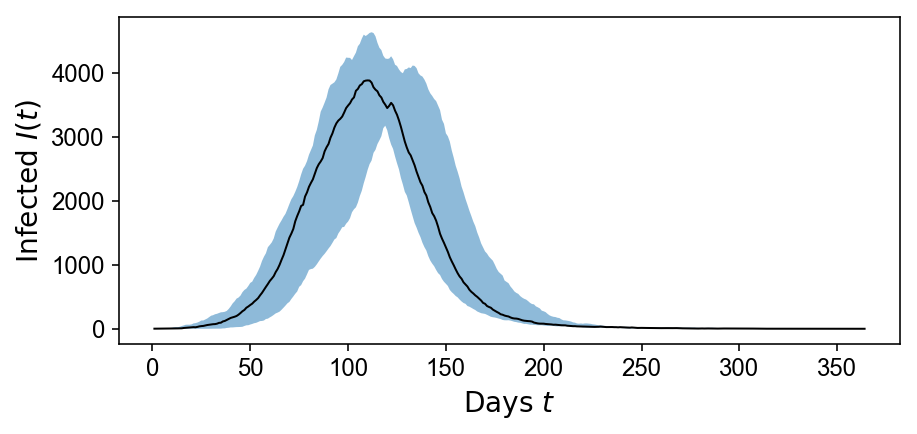

In [10]:
fig,ax = plt.subplots(figsize=(7,3))
ax = textPlot(ax, 12, 'Arial')
plt.plot(k.index,ih[1], color='black', lw=1)
ax.fill_between(k.index, ih[0], ih[2], alpha=0.5)
ax.set_xlabel('Days '+r'$t$', size = 14)
ax.set_ylabel('Infected '+r'$I(t)$', size = 14)

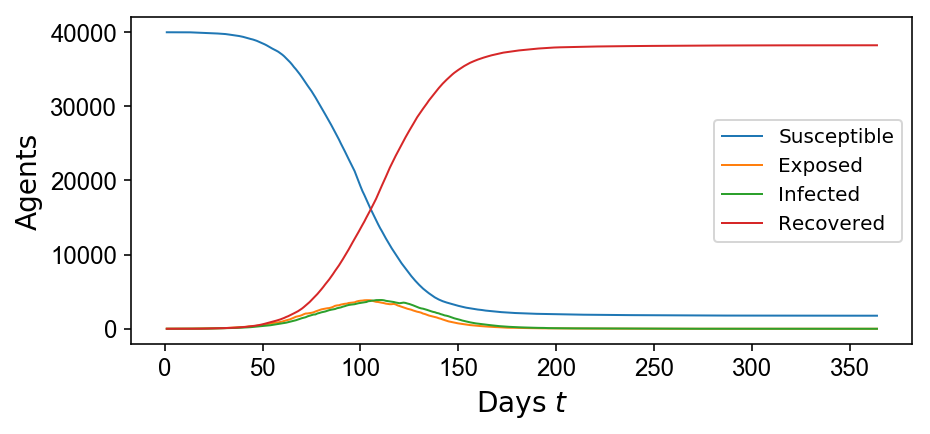

In [11]:
fig,ax = plt.subplots(figsize=(7,3))
ax = textPlot(ax, 12, 'Arial')
plt.plot(k.index,sh[1],  lw=1, label='Susceptible')
plt.plot(k.index,eh[1],  lw=1, label='Exposed')
plt.plot(k.index,ih[1],  lw=1, label='Infected')
plt.plot(k.index,rh[1],  lw=1, label='Recovered')
ax.set_xlabel('Days '+r'$t$', size = 14);
ax.set_ylabel('Agents', size = 14);
ax.legend();

### 3.3 Spatial Diffusion: Recovered Individuals


In [ ]:
infH = []  ## infected humans
M = []
gs = 20
for i in range(0, 363):
    M.append(np.zeros((gs,gs)))

for i in fileName:
    df = pd.read_csv(pathRes+i, sep=' ') ## read the file
    count = 0
    for t in range(1, 364):
        tmp = df[df['Time']==t]
        k = tmp.groupby('Node').sum()
        for j in k.index:
            x = j%gs
            y = j//gs
            M[t-1][x,y]+=k['R'][j]
M = np.true_divide(M, s) ## take the average

In [ ]:
days = [20,40,60,80]
fig, ax = plt.subplots(2, 2, figsize=(10,10))
d = 0
for i in range(0,2):
    for j in range(0,2):
        t = days[d]
        ax1 = ax[i][j]
        ax1 = textPlot(ax1, 12, 'Arial')
        im = ax1.imshow(M[t], cmap='CMRmap_r',vmin=0, vmax=100)
        ax1.set_title('Day=%d'%t)
        ax1.set_xticks([-0.5,4.5,9.5,14.5,19.5])
        ax1.set_xticklabels([0,5,10,15,20])
        ax1.set_yticks([-0.5,4.5,9.5,14.5,19.5])
        ax1.set_yticklabels([0,5,10,15,20])
        plt.colorbar(im,ax=ax1)
        d+=1